# Homework 3 - von Neumann

Let's gather up everything we need and create some plots to start:

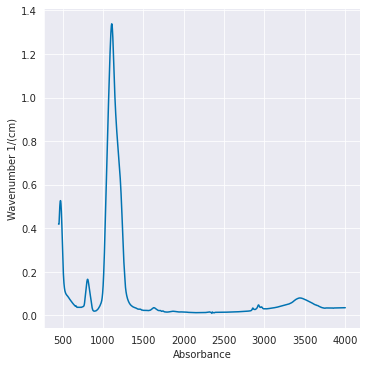

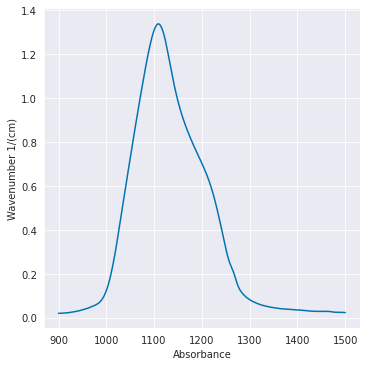

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = (pd.read_csv('data/Silica.csv', header=None)
    .rename(columns={0:"Wavenumber 1/(cm)", 1:"Absorbance"})
    .set_index("Wavenumber 1/(cm)"))

df = df.iloc[::-1]  # this is to flip the dataframe, so we have it ordered from low to high wavenumbers.

sns.set_style("darkgrid")
sns.set_palette("colorblind")  # This time we are thoughtful :)

plot = sns.relplot(data=df, kind="line", legend=False)
plot.set(xlabel='Absorbance', ylabel='Wavenumber 1/(cm)')
plt.show()

dfr = df[900:1500]
plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Absorbance', ylabel='Wavenumber 1/(cm)')
plt.savefig(f'sns.png', bbox_inches='tight')
plt.show()


#### Let's first try to identify the peak points on the graph to decide where to put all the Gaussians. After adding a few more gridlines, just eyeballing it, the first three look clear to get an idea, so we can pinpoint them exactly later:

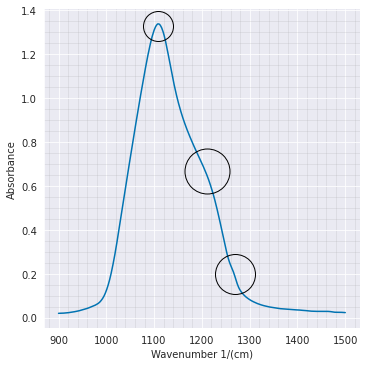

In [2]:
sns.set_style()
plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot([1109],[1.33],'o', ms=30, mec='k', mfc='none')
plt.plot([1210],[0.67],'o', ms=45, mec='k', mfc='none')
plt.plot([1270],[0.20],'o', ms=40, mec='k', mfc='none')
plt.show()

#### Let's take a closer look at the 1350 - 1500 range to pick the other two:

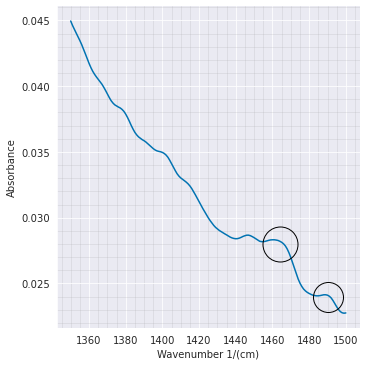

In [3]:
plot2 = sns.relplot(data=dfr[1350:1500], kind='line', legend=False)
plot2.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot([1464],[0.028],'o', ms=35, mec='k', mfc='none')
plt.plot([1490],[0.024],'o', ms=30, mec='k', mfc='none')
plt.show()

#### There's a bunch we can choose from, but the more significant ones seem to be around wavenumbers 1465 and 1490.
 We have a few good starting points now, we can begin analyzing!
 
 _A note from the future: we don't end up actually using these points, but we've decided to keep them here to make the thought process more live! 8)_

# Using 3 Gaussians:

In [4]:
def Gauss(x,A,mu,sigma):
    y = A*np.exp(-(x-mu)**2/(2*sigma**2))
    return y
dfr

,Absorbance
Wavenumber 1/(cm),
900.0,0.01941
901.0,0.01946
902.0,0.01951
903.0,0.01954
904.0,0.01957
...,...
1496.0,0.02302
1497.0,0.02286
1498.0,0.02277


Let's first try to catch that peak point to start, right onto the ymax point:

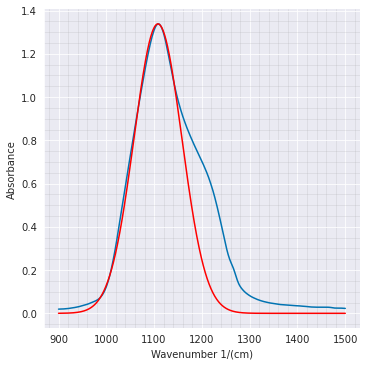

In [5]:
ymax = dfr.max().values[0]
x_ymax = dfr.idxmax().values[0]
x = dfr.index.values

gauss1 = Gauss(x, ymax, x_ymax, 50)  # The 50 sigma value there fit great right away, lucky guess 8)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.show()

For the second, we can try zooming into the 1200-1250 range:

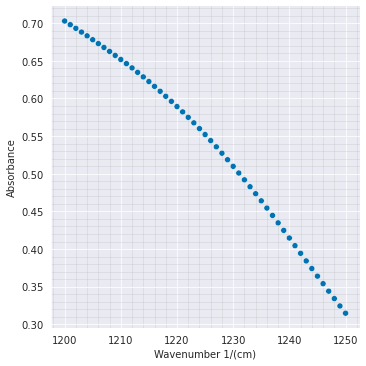

In [6]:
plot3 = sns.relplot(data=dfr[1200:1250], legend=False)
plot3.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

Somewhere around 1220 looks like the right point, but to find where the optimal point is for sure, it would have been nice to check the second derivative of this function, we can reason that the optimal point would be the point with the minimum second derivative, as that will be the point in which the function would have its largest "concave downward", so we can try hacking this numerically, creating our own fake derivative by checking the slopes at all points:

In [7]:
def fake_derivative(dataframe, x_from, x_to):
    
    # Here x_from:x_to will be a range in df.index.values, like 1200:1250 in our case,
    # we will have the function take all "derivatives" for all of these points.
    
    fake_derivatives = np.empty(0)
    x_values = dataframe[x_from:x_to].index.values
    y_values = dataframe[x_from:x_to].values
    
    # We are going to define delta x as dx = x(i+1) - x(i), so we need to write the for loop
    # with the indexes, rather than the objects:
    # (the delta x values will all be -1 in this case of course, but we want to code generally 8))
    
    for i in range(len(x_values)-1):  # -1 is needed because we call on the i+1 index
        x1, x2 = x_values[i], x_values[i+1]
        y1, y2 = y_values[i], y_values[i+1]
        dx = x2 - x1
        dy = y2 - y1
        fake_derivative = dy/dx
        fake_derivatives = np.append(fake_derivatives, fake_derivative)
        
    x_values_dropone = x_values[:-1]  # We need to drop the last value, otherwise we have
        # one more index than we have derivatives, and Pandas doesn't like that.
        
    # Now we can put these together in a DataFrame:
    fake_derivatives_dataframe = pd.DataFrame({"x":x_values_dropone, 
                            "Slopes":fake_derivatives}).set_index("x")
    
    return fake_derivatives_dataframe

In [8]:
fake_derivative(dfr, 1200, 1250).head(10)

,Slopes
x,
1200.0,-0.00487
1201.0,-0.00488
1202.0,-0.00492
1203.0,-0.00505
1204.0,-0.00515
1205.0,-0.00513
1206.0,-0.00513
1207.0,-0.00525
1208.0,-0.00535


Well that has worked swimmingly, I think, but to get the "second derivatives" we need to run it again on this dataframe:

In [9]:
d_dfr = fake_derivative(dfr, 1200, 1250)
dd_dfr = fake_derivative(d_dfr, 1200, 1249)  # again we drop one value here to line them up, which could be
# a potential problem for the function, but is fine for our case, as we care more about the 1215-1230 range.
dd_dfr.head(10)

,Slopes
x,
1200.0,-1.000000e-05
1201.0,-4.000000e-05
1202.0,-1.300000e-04
1203.0,-1.000000e-04
1204.0,2.000000e-05
1205.0,-1.110223e-16
1206.0,-1.200000e-04
1207.0,-1.000000e-04
1208.0,-5.000000e-05


In [10]:
dd_dfr.idxmin()  # we are looking at negative derivatives here, so we will take the min value

Slopes    1222.0
dtype: float64

Well there it is, the point we need seems to be 1222, so our eyeball guess was actually pretty close, let's see if it was worth all the effort!

When we put our second gaussian here, we want the sum of the two at that peak point to be equal to the actual values we have at 1222, so let's call the old gauss1 we have defined, and see the difference it has to the point 1222, that will be the magnitude of our second gaussian.

In [55]:
g1_1222 = gauss1[np.where(x == 1222)]
dfr_1222 = dfr.loc[1222].values[0]
A2 = dfr_1222 - g1_1222

gauss2 = Gauss(x, A2, 1222, 20)  # time to plot!

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss1 + gauss2, "--k")
plt.show()

IndexError: index 322 is out of bounds for axis 0 with size 0

We've hit our spot, as expected, but we need to make that 20 sigma a bit larger to get the sides to fit, however if we only adjust the sigma of this one, we are limited by the previous peak we got, as this second Gaussian gets spread out, it starts to affect the territory of the first one, so the best way to get a good fit here would be to also adjust the max value for the first Gaussian. To do this right, we want to know how much the second Gaussian is affecting the ymax point, so we can check that value as we adjust the sigma, and automatically adjust the magnitude of the first one.

I'm going to call this value `interference2`, and it is just the value of gauss2 at x_ymax:

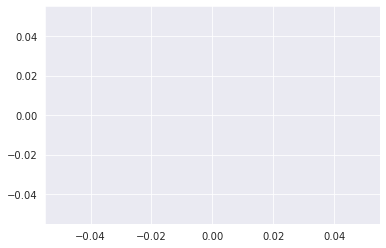

In [39]:
gaussa = Gauss(, ymax, x_ymax, 50)

gaussb = Gauss(, A2, 1222, 20)

So this picture now screams "please put the third Gaussian in the middle of the two to fill the gap", looks like that area matters a lot more than the small peaks we have found by zooming in, because if we want to get the peak points exactly right, there's nothing much more we can do for the rest with these two Gaussians, so let's use the third one as a filler.

We can start by determining the largest difference between the made up function that's the sum of our two Gaussians, and the actual data. We can easily find all of these differences in a for loop, between values 1160 and 1200:

In [13]:
g1g2 = gauss1 + gauss2

g1g2_errors = np.empty(0)

for i in range(1160,1200):
    
    gauss_value = g1g2[np.where(x == i)][0]
    real_value = dfr.loc[i].values[0]
    error = real_value - gauss_value
    g1g2_errors = np.append(g1g2_errors, error)

g1g2_max_error = g1g2_errors.max()
ind = np.where(g1g2_errors == g1g2_errors.max())[0][0] # this is the index that has the max error 0-39
actual_index = range(1160,1200)[ind] # this is the index in our range.
print(f"Maximum error is {g1g2_max_error} at wavenumber {actual_index}")

Maximum error is 0.1450056127487951 at wavenumber 1181


The wavenumber 1185 has the maximum value at this point, so we can put our third Gaussian there to plug the hole, and we can pick its amplitude to be equal to `g1g2_max_error`. We can also do the same calculation with interference as last time, I'm not going to make it large enough to affect the first peak, so we can just focus on the 2nd one:

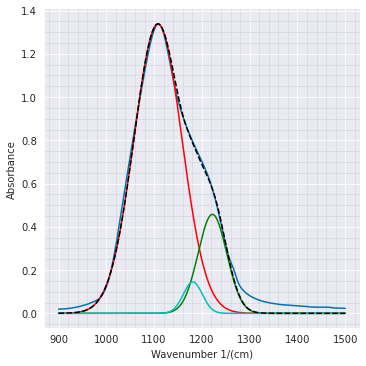

In [14]:
A3 = g1g2_max_error
gauss3 = Gauss(x, A3, actual_index, 20)

interference3 = gauss3[np.where(x == 1222)]
gauss2 = gauss2 = Gauss(x, A2 - interference3, 1222, 30)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss3, "c")
plt.plot(x, gauss1 + gauss2 + gauss3, "--k")
plt.show()

Looks great, we can be proud of that 8)! Let's write down a quick error function to see how we actually did:

In [15]:
def gauss_vs_reals(dataframe, gaussians_df, x_from, x_to):
    real_values = dataframe[x_from:x_to].values
    gauss_values = gaussians_df[x_from:x_to].values
    total_error = 0
    total_error_percent = 0
    
    for i in range(x_to - x_from + 1):
        
        error = real_values[i][0] - gauss_values[i][0]
        total_error += error
    
    total_error_percent = total_error / np.sum(real_values) * 100
    return (total_error, total_error_percent)

In [16]:
g1g2g3 = gauss1 + gauss2 + gauss3
indexes_123 = np.arange(900,1501, dtype="float") # apparently, the df[x1:x2] call only works for float indexes?
gauss123_df = pd.DataFrame({"x":indexes_123, "Values":g1g2g3}).set_index("x")

errors123 = gauss_vs_reals(dfr, gauss123_df, 900, 1500)
print(f"The total error is {errors123[1]} %")

The total error is 5.377666549144154 %


5.4% is not bad, but is also not really a very fair way to analyze the error, as the parts we are focusing are in the range 980-1300 for this part, let's also run it for that range:

In [17]:
errors123_2 = gauss_vs_reals(dfr, gauss123_df, 980, 1300)
print(f"The total error is {errors123_2[1]} %")

The total error is 1.2317810847846749 %


Much better!

### Coefficient of Determination for 3 Gaussians:

## Using 4 Gaussians:

Strategizing from here, we can go a couple different ways; we can nitpick on the smaller peaks we have found by zooming in, we can add a largely spread Gaussian with a small amplitude on the right side to close the gap, or we could focus on the slight deviation we have from the left side of the large curve, as we have a lot of control over the right side of the large curve (since we have our two smaller Gaussians there) we could make the first red Gaussian thinner and fill up the left side. But considering the entire range it does seem like the best choice for a fourth Gaussian will be to focus on the right side of the third Gaussian, the 1280+ range, we have a lot of deviation there.

We can start the same way we did for the third Gaussian, by finding point with the largest error, so copy-pasting the code:

In [18]:
g1g2g3_errors = np.empty(0)

for i in range(1280,1500):
    
    gauss_value = g1g2g3[np.where(x == i)][0]
    real_value = dfr.loc[i].values[0]
    error = real_value - gauss_value
    g1g2g3_errors = np.append(g1g2g3_errors, error)
    
g1g2g3_max_error = g1g2g3_errors.max()
ind123 = np.where(g1g2_errors == g1g2_errors.max())[0][0]
actual_index123 = range(1280,1500)[ind]
print(f"Maximum error is {g1g2g3_max_error} at wavenumber {actual_index123}")

Maximum error is 0.06524466929726622 at wavenumber 1301


1301 is the point, again just eyeballing it we would have said 1300 anyway 8)